In [24]:
# Dependencies
import networkx as nx
import matplotlib.pyplot as plt


In [25]:
# Classes
class State():
    def __init__(self, name):
        self.name = name
        self.final = False
        self.edges = []

    def add_edge(self, destiny, transition, output=0):
        edge = Edge(self.name, destiny, transition, output)
        self.edges.append(edge)
        # print("Adicionei edge de {} para {} com {} e output {}".format(
        #     edge.origin, edge.destiny, edge.transition, edge.output))

    def add_state_to_fst(self, fst):
        fst.add_node(self.name, final=self.final)

    def add_edges_to_fst(self, fst):
        for edge in self.edges:
            fst.add_edge(edge.origin, edge.destiny,
                         transition=edge.transition, output=edge.output)

    def set_final(self, is_final):
        self.final = is_final

    def is_equal(self, state):
        if self.final != state.final:
            # print("Final Diferente")
            return False
        if len(self.edges) != len(state.edges):
            # print("Numero edges diferente")
            return False
        for edge in self.edges:
            found_equivalent = False
            for state_edge in state.edges:
                if (edge.destiny == state_edge.destiny and edge.transition == state_edge.transition and edge.output == state_edge.output):
                    found_equivalent = True
                    break
            if found_equivalent:
                continue
            # print("Nao achou equivalente")
            return False
        return True

    def output(self, destiny):
        for edge in self.edges:
            if (edge.destiny == destiny):
                return edge.output
        return None

    def clear(self):
        self.final = False
        self.edges = []

    def copy(self):
        new_state = State(self.name)
        new_state.set_final(self.final)
        for edge in self.edges:
            new_state.add_edge(edge.destiny, edge.transition, edge.output)
        return new_state

    def rename(self, name):
        self.name = name
        for edge in self.edges:
            edge.origin = name

    def remove_edge(self, destiny, transition):
        to_be_removed_edge = None
        for edge in self.edges:
            if (edge.destiny == destiny and edge.transition == transition):
                to_be_removed_edge = edge
                break
        if to_be_removed_edge != None:
            # print("Removi edge {} para {} com e output {}".format(
            #     edge.origin, edge.destiny, edge.transition, edge.output))
            self.edges.remove(to_be_removed_edge)

    def set_output(self, destiny, new_output):
        for edge in self.edges:
            if edge.destiny == destiny:
                edge.output = new_output
                # print("Setei {} de {} para {} com {}".format(
                #     edge.output, edge.origin, edge.destiny, edge.transition))

    def correct_edges(self, fator):
        for edge in self.edges:
            # print(edge.output)
            edge.output = edge.output + fator
            # print("Corrigi edge de {} para {} de transicao {} com {}".format(
            #     edge.origin, edge.destiny, edge.transition, edge.output))


class Edge():
    def __init__(self, origin, destiny, transition, output):
        self.origin = origin
        self.destiny = destiny
        self.transition = transition
        self.output = output


In [26]:
# Utils
def findMinimizedState(state, minimal_states, max_word_size):
    for frozen_state in minimal_states:
        if frozen_state.is_equal(state):
            # print("Estado Equivalente, {}, Final:{}, Edges:{}".format(frozen_state.name, frozen_state.final, len(frozen_state.edges)))
            # for edge in frozen_state.edges:
            #     print("Origem:{}, Destino:{}, Transicao:{}, Output:{}".format(edge.origin, edge.destiny, edge.transition, edge.output))
            return frozen_state
    new_state = state.copy()
    new_state.rename(len(minimal_states)+max_word_size+1)
    # print("Novo Estado Minimizado, {}, Final:{}, Edges:{}".format(new_state.name, new_state.final, len(new_state.edges)))
    # for edge in new_state.edges:
    #     print("Origem:{}, Destino:{}, Transicao:{}, Output:{}".format(edge.origin, edge.destiny, edge.transition, edge.output))
    minimal_states.append(new_state)
    # for stat in minimal_states:
    #     print("Estado: {}, Final:{}, Edges:{}".format(stat.name, stat.final, len(stat.edges)))
    return new_state


def findMaxWordSize(dictionary):
    max_word_size = 0
    for word in dictionary.keys():
        if len(word) > max_word_size:
            max_word_size = len(word)
    return max_word_size


In [27]:
# Create Minimal Transducer
def create_minimal_transducer(dictionary):
    # Initial

    fst = nx.MultiDiGraph()
    minimal_states = []
    max_word_size = findMaxWordSize(dictionary)
    # print(max_word_size)
    temp_states = []
    for i in range(0, max_word_size + 1):
        temp_state = State(i)
        temp_states.append(temp_state)

    # Algorithm

    prev_word = ""
    current_word = ""

    for word, index in dictionary.items():
        current_word = word
        # print(current_word)
        # Longest Prefix
        prefix_len = 0
        while (prefix_len < len(current_word) and prefix_len < len(prev_word) and prev_word[prefix_len] == current_word[prefix_len]):
            prefix_len = prefix_len + 1
        # Minimize States from Suffix of the Previous Word
        for i in range(len(prev_word),prefix_len, -1):
            cur_output = temp_states[i-1].output(temp_states[i].name)
            # print(cur_output)
            temp_states[i-1].remove_edge(temp_states[i].name,prev_word[i-1])
            temp_states[i-1].add_edge(findMinimizedState(temp_states[i],minimal_states, max_word_size).name,prev_word[i-1], cur_output)
            temp_states[i].clear()
        # Initializes Tail States for the Current Word
        for i in range(prefix_len,len(current_word)):
            temp_states[i].add_edge(temp_states[i+1].name,current_word[i])
        if current_word != prev_word:
            temp_states[len(current_word)].set_final(True)
        # Fixing Outputs
        missing_output = index
        for i in range(0, prefix_len+1):
            # print(missing_output)
            if i == prefix_len:
                temp_states[i].set_output(temp_states[i+1].name, missing_output)
                break
            cur_output = temp_states[i].output(temp_states[i+1].name)
            # print(cur_output)
            new_output = min(missing_output, cur_output)
            # print(new_output)
            temp_states[i].set_output(temp_states[i+1].name, new_output)

            dif_output = cur_output - new_output

            temp_states[i+1].correct_edges(dif_output)
            
            missing_output = missing_output - new_output
            

        prev_word = current_word
    
    # Minimizing States for Last Word
    for i in range(len(current_word),0,-1):
        cur_output = temp_states[i-1].output(temp_states[i].name)
        temp_states[i-1].remove_edge(temp_states[i].name,current_word[i-1])
        temp_states[i-1].add_edge(findMinimizedState(temp_states[i],minimal_states, max_word_size).name,current_word[i-1], cur_output)
        temp_states[i].clear()
    
    # Adding starting state
    new_state = temp_states[0].copy()
    new_state.rename(0)
    minimal_states.append(new_state)
            

    # Creating FST based on list
    
    # for stat in minimal_states:
    #     print("Estado: {}, Final:{}, Edges:{}".format(stat.name, stat.final, len(stat.edges)))
    #     for edge in stat.edges:
    #         print("Origem:{}, Destino:{}, Transicao:{}, Output:{}".format(edge.origin, edge.destiny, edge.transition, edge.output))

    for state in minimal_states:
        state.add_state_to_fst(fst)
    for state in minimal_states:
        state.add_edges_to_fst(fst)
    
    return fst


In [28]:
# Create Dictionary
def create_dictionary():
    dictionary = {"jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6,
                  "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12}
    dictionary = dict(sorted(dictionary.items()))
    return dictionary


In [29]:
# Read Input

def read_input(input, fst):
    state = 0
    output = 0
    for letter in input:
        current_state_edges = dict(fst[state])
        prev_state = state
        for next_state, edge_properties in current_state_edges.items():
            for index, edge in edge_properties.items():
                if edge['transition'] == letter:
                    state = next_state
                    output += edge['output'] 
                    break
        if (state == prev_state):
            print("Nao chegou ao fim")
            break
    return output

In [30]:
# Autocomplete

def auto_complete(input, fst):
    state = 0

    for letter in input:
        current_state_edges = dict(fst[state])
        prev_state = state
        for next_state, edge_properties in current_state_edges.items():
            for index, edge in edge_properties.items():
                if edge['transition'] == letter:
                    state = next_state
                    break
        if (state == prev_state):
            return "Não existe"
    
    print(state)
    queue = [(state, input)]
    autocomplete_list = []

    while len(queue) > 0 and len(autocomplete_list) < 5:
        current_pair = queue.pop(0)
        current_state = current_pair[0]
        print("Atual:{}".format(current_state))
        # Adding final words to autocomplete_list
        if fst.nodes[current_state]["final"]:
            autocomplete_list.append(current_pair[1])
        # Adding New States to BFS
        current_state_edges = dict(fst[current_state])
        for next_state, edge_properties in current_state_edges.items():
            for index, edge in edge_properties.items():
                print("Proximo:{}".format(next_state))
                queue.append((next_state, current_pair[1]+edge['transition']))

    return autocomplete_list


Nao chegou ao fim
3
9
Atual:9
Proximo:6
Proximo:8
Atual:6
Proximo:5
Atual:8
Proximo:7
Atual:5
Atual:7
Proximo:5
Atual:5
['apr', 'augu']


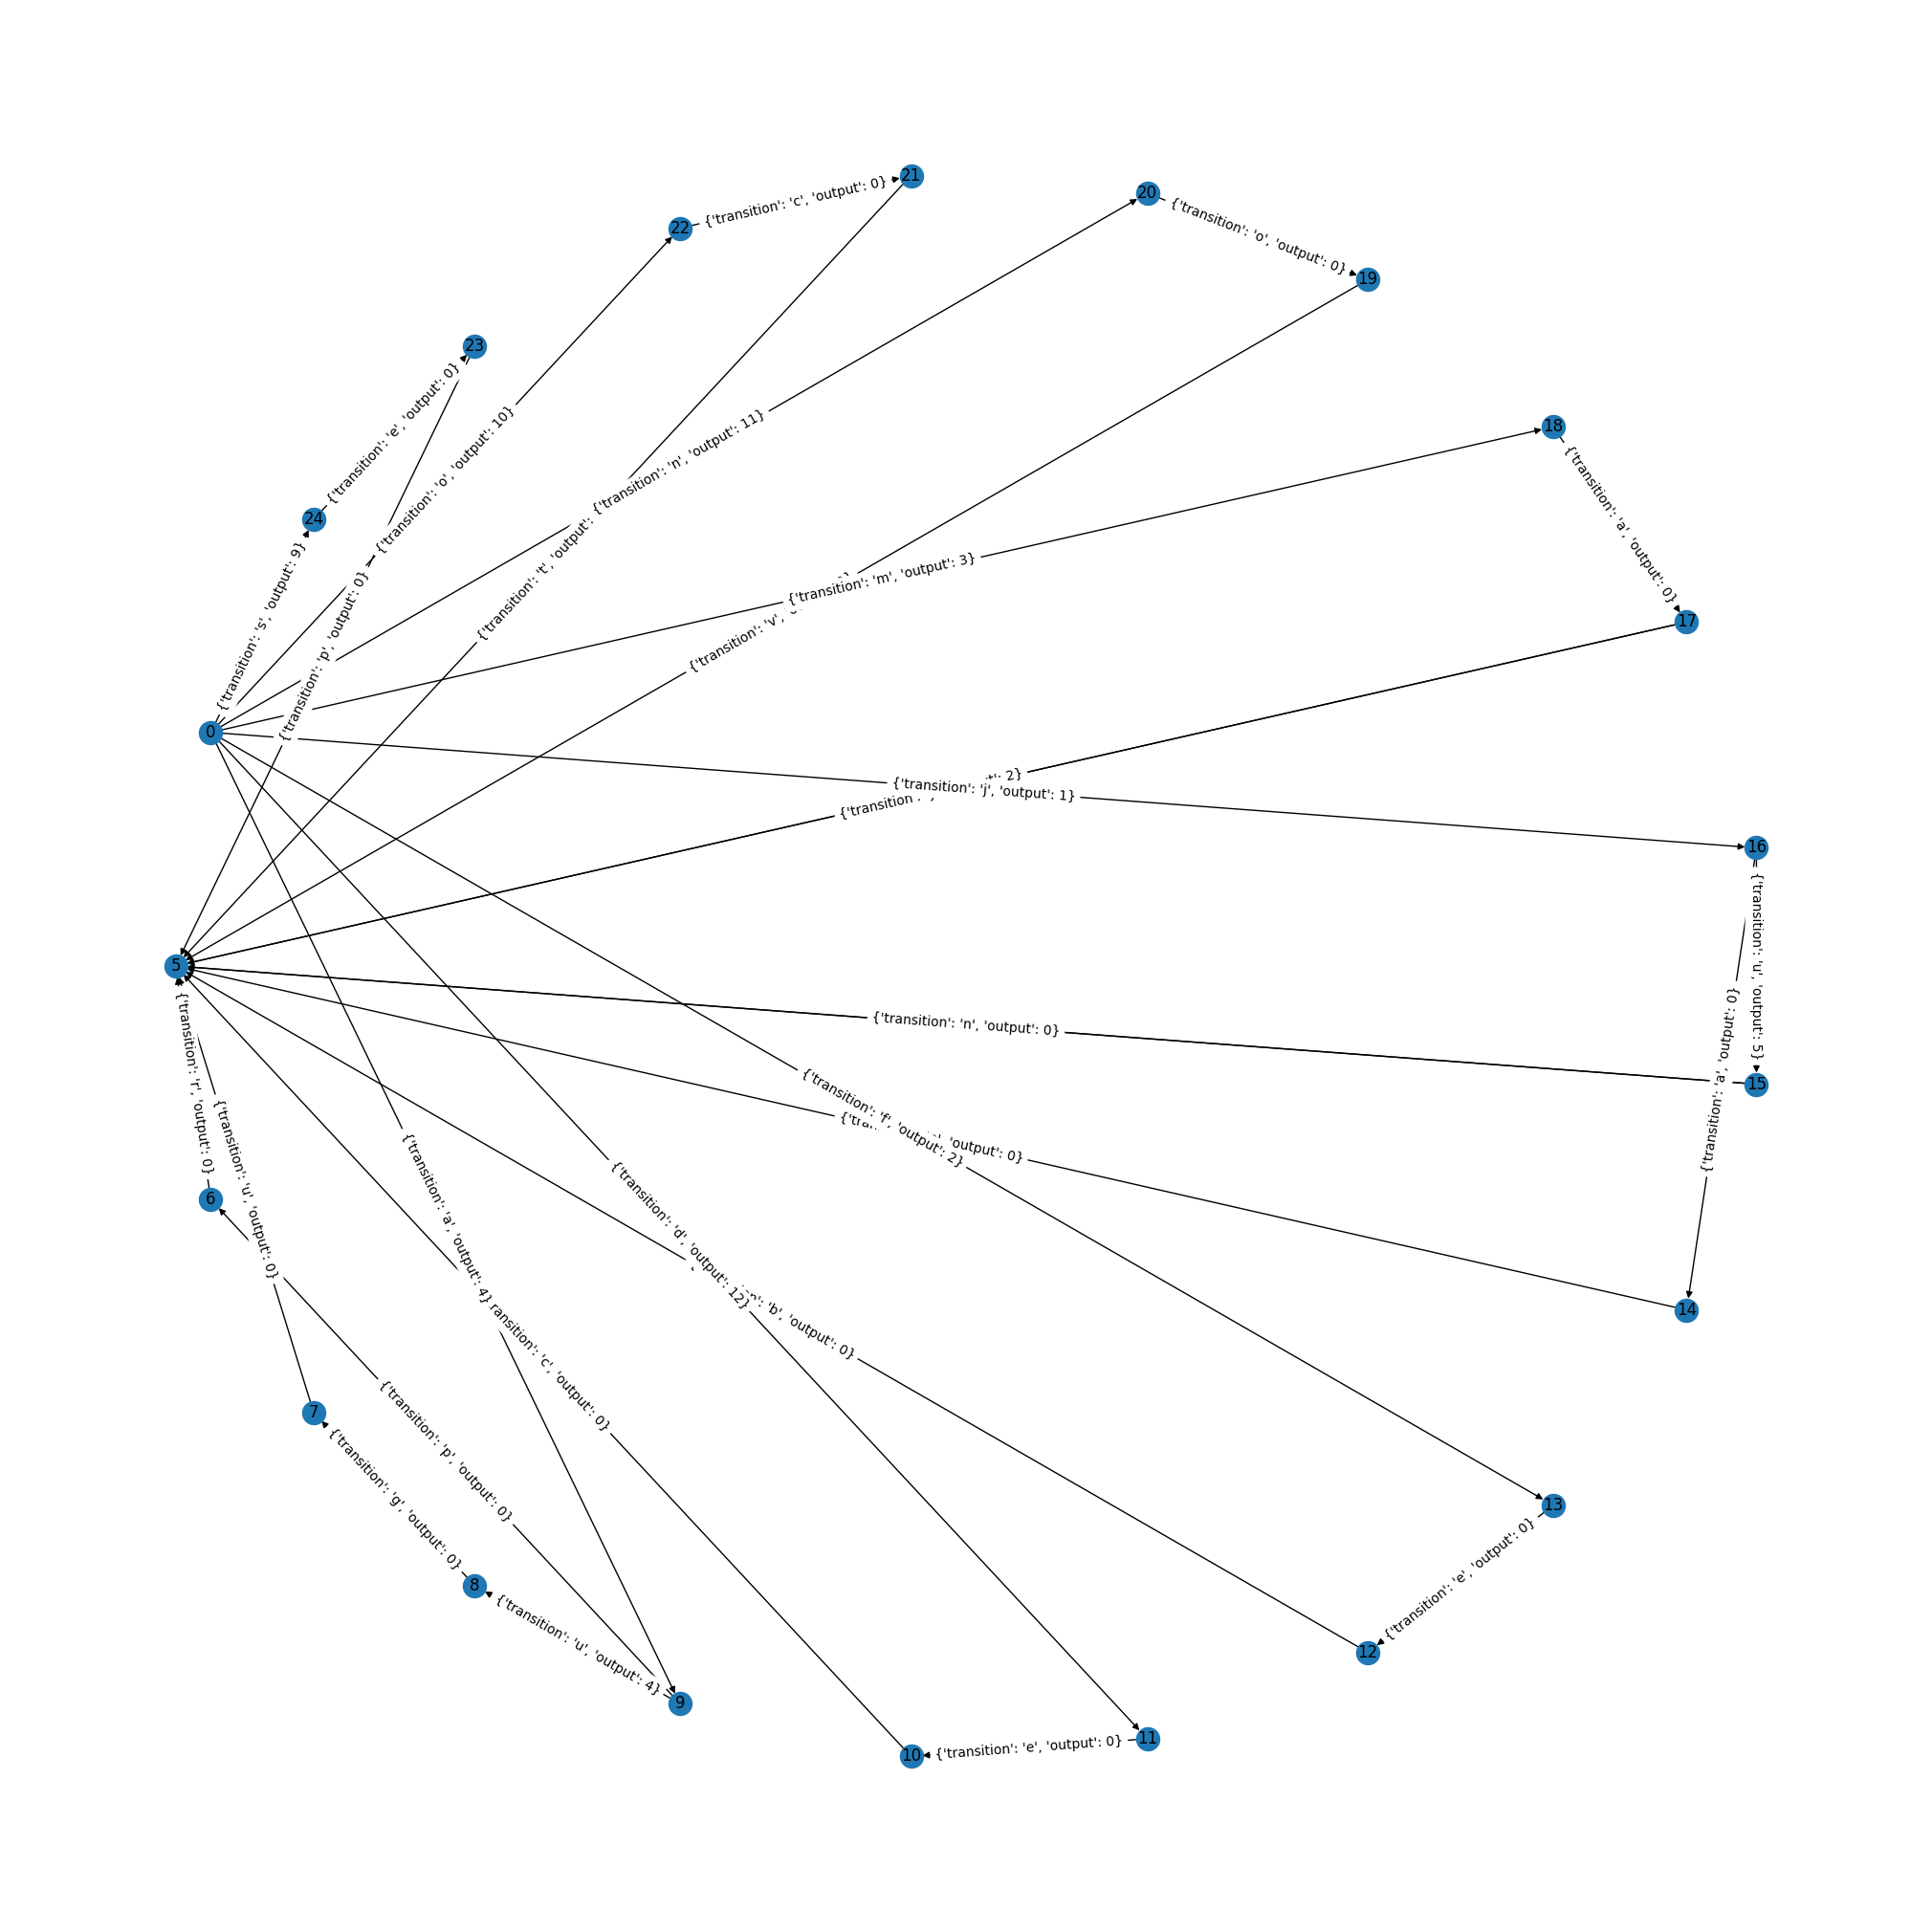

In [32]:
# Main

dictionary = create_dictionary()
fst = create_minimal_transducer(dictionary)
pos = nx.shell_layout(fst)
plt.figure(figsize=(20,20))
nx.draw(fst, pos, with_labels=True)
nx.draw_networkx_edge_labels(fst, pos)


print(read_input("mat",fst))
print(auto_complete('a',fst))